In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#$from google.colab import files
from pathlib import Path
import shutil

In [2]:
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73031 sha256=690200f4f00ba3f8852532b1eed4e7b796d90b160a75af3691de7c442578d7a7
  Stored in directory: /root/.cache/pip/wheels/ac/b2/c3/fa4706d469b5879105991d1c8be9a3c2ef329ba9fe2ce5085e
Successfully built kaggle


In [3]:
#files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c datathonindoml-2022

 99%|█████████████████████████████████████▌| 1.49G/1.51G [00:29<00:00, 75.5MB/s]
100%|██████████████████████████████████████| 1.51G/1.51G [00:29<00:00, 55.8MB/s]


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [5]:
local_zip = '/notebooks/datathonindoml-2022.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/notebooks/data')
zip_ref.close()

In [6]:
base_dir = '/notebooks/data'
train_dir = os.path.join(base_dir, 'train/train')
valid_dir = os.path.join(base_dir, 'validation/validation')

In [7]:
classes = {
    0:'memo',
    1:'form',
    2:'email',
    3:'handwritten',
    4:'advertisement',
    5:'scientific_report',
    6:'scientific_publication',
    7:'specification',
    8:'file_folder',
    9:'news_article',
    10:'budget',
    11:'invoice',
    12:'presentation',
    13:'questionaire',
    14:'resume',
    15:'letter'
}

In [8]:
for (key,value) in classes.items():
  path = os.path.join(train_dir, value)
  os.mkdir(path)

In [9]:
train_labels = pd.read_csv(base_dir+'/train_labels.csv')
train_labels.head(5)

,id,label
0,0,1
1,1,13
2,2,13
3,3,14
4,4,6


In [10]:
def push_to_dir(key, value, dir):
  file_ids = train_labels[train_labels['label']==key]['id'].values
  for file_id in file_ids:
    shutil.move(os.path.join(dir,str(file_id))+'.tif', os.path.join(os.path.join(dir,value),str(file_id))+'.tif')

for key,value in classes.items():
  push_to_dir(key,value,train_dir)

In [11]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        color_mode='rgb',
        class_mode='categorical',
        subset='training')

Found 12807 images belonging to 16 classes.


In [12]:
valid_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        color_mode='rgb',
        class_mode='categorical',
        subset='validation')

Found 3193 images belonging to 16 classes.



Class Type = invoice, filename = 2000.tif


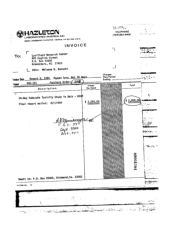


Class Type = resume, filename = 984.tif


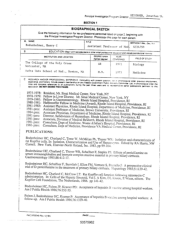


Class Type = letter, filename = 1244.tif


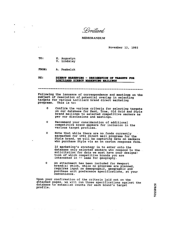


Class Type = presentation, filename = 11199.tif


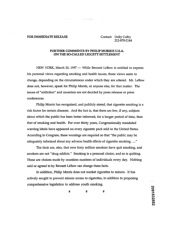


Class Type = specification, filename = 8584.tif


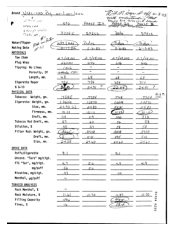


Class Type = questionaire, filename = 6918.tif


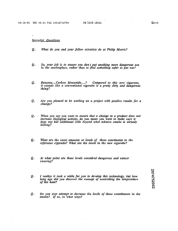


Class Type = news_article, filename = 15444.tif


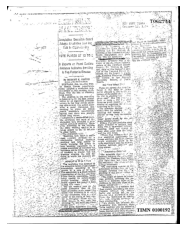


Class Type = memo, filename = 881.tif


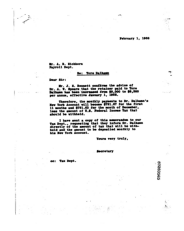


Class Type = scientific_publication, filename = 13552.tif


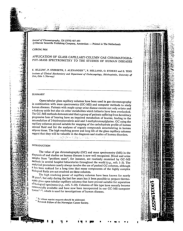


Class Type = email, filename = 320.tif


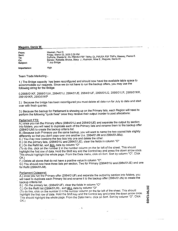


Class Type = budget, filename = 2124.tif


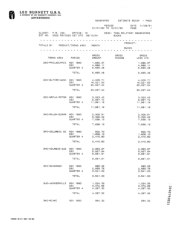


Class Type = form, filename = 10668.tif


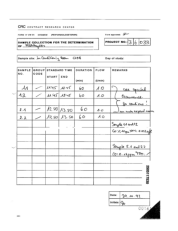


Class Type = handwritten, filename = 7278.tif


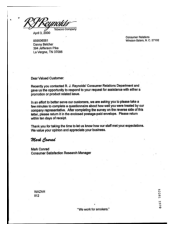


Class Type = advertisement, filename = 14831.tif


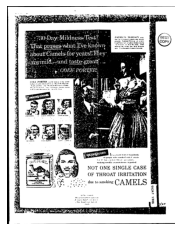


Class Type = scientific_report, filename = 12380.tif


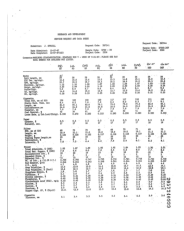


Class Type = file_folder, filename = 6613.tif


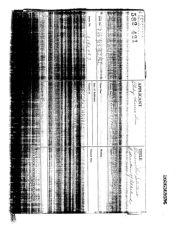

In [13]:
train_classes_dir = os.listdir(train_dir)

for label in train_classes_dir:
  i = 1
  path = os.path.join(train_dir, label)
  fname = os.listdir(path)[0]
  image = cv2.imread(os.path.join(path,fname))
  print(f'\nClass Type = {label}, filename = {fname}')
  plt.axis('off')
  plt.imshow(image)
  plt.show()

In [14]:
def GoogleNet(classes):
  from keras.applications.inception_v3 import InceptionV3
  base_model = InceptionV3(input_shape = (224,224,3), weights='imagenet', include_top=False)
  base_model.trainable = False
  model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(name='GlobalAvgPooling_Layer'),
    tf.keras.layers.Dropout(0.4, name='Dropout_Layer'),
    tf.keras.layers.Dense(classes, activation='softmax', name='Output_Layer')
  ])

  model.summary()

  model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001, momentum=0.9), metrics = ['accuracy'])
  return model

In [15]:
def lr_scheduler(epoch):
  return 0.001*(1-(epoch/60.0))**0.5

In [16]:
googlenet_model = GoogleNet(classes = 16)

87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 GlobalAvgPooling_Layer (Glo  (None, 2048)             0         
 balAveragePooling2D)                                            
                                                                 
 Dropout_Layer (Dropout)     (None, 2048)              0         
                                                                 
 Output_Layer (Dense)        (None, 16)                32784     
                                                                 
Total params: 21,835,568
Trainable params: 32,784
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
googlenet_history = googlenet_model.fit(train_generator, epochs=40, validation_data = valid_generator,verbose = 1, callbacks=[callbacks])

Epoch 1/40
351/351 [==============================] - 131s 362ms/step - loss: 2.4466 - accuracy: 0.2312 - val_loss: 2.0600 - val_accuracy: 0.4185
Epoch 2/40
351/351 [==============================] - 126s 360ms/step - loss: 2.0205 - accuracy: 0.3858 - val_loss: 1.8326 - val_accuracy: 0.4711
Epoch 3/40
351/351 [==============================] - 126s 359ms/step - loss: 1.8569 - accuracy: 0.4254 - val_loss: 1.7118 - val_accuracy: 0.4893
Epoch 4/40
351/351 [==============================] - 126s 359ms/step - loss: 1.7559 - accuracy: 0.4579 - val_loss: 1.6450 - val_accuracy: 0.5005
Epoch 5/40
351/351 [==============================] - 126s 359ms/step - loss: 1.6905 - accuracy: 0.4776 - val_loss: 1.5959 - val_accuracy: 0.5116
Epoch 6/40
351/351 [==============================] - 126s 360ms/step - loss: 1.6458 - accuracy: 0.4866 - val_loss: 1.5524 - val_accuracy: 0.5249
Epoch 7/40
351/351 [==============================] - 126s 359ms/step - loss: 1.6064 - accuracy: 0.5018 - val_loss: 1.5221 -

In [17]:
schedule = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
googlenet_history = googlenet_model.fit(googlenet_model.fit(train_generator, epochs=60, validation_data = valid_generator,verbose = 1, callbacks=[schedule]))

Epoch 1/60
401/401 [==============================] - 130s 298ms/step - loss: 2.1365 - accuracy: 0.3427 - val_loss: 1.7092 - val_accuracy: 0.4773 - lr: 0.0010
Epoch 2/60
401/401 [==============================] - 127s 317ms/step - loss: 1.7687 - accuracy: 0.4554 - val_loss: 1.6124 - val_accuracy: 0.4955 - lr: 9.9163e-04
Epoch 3/60
401/401 [==============================] - 127s 316ms/step - loss: 1.6719 - accuracy: 0.4865 - val_loss: 1.5629 - val_accuracy: 0.5233 - lr: 9.8319e-04
Epoch 4/60
401/401 [==============================] - 129s 322ms/step - loss: 1.6196 - accuracy: 0.4986 - val_loss: 1.5134 - val_accuracy: 0.5399 - lr: 9.7468e-04
Epoch 5/60
401/401 [==============================] - 133s 331ms/step - loss: 1.5807 - accuracy: 0.5141 - val_loss: 1.4811 - val_accuracy: 0.5490 - lr: 9.6609e-04
Epoch 6/60
401/401 [==============================] - 133s 330ms/step - loss: 1.5480 - accuracy: 0.5202 - val_loss: 1.4734 - val_accuracy: 0.5565 - lr: 9.5743e-04
Epoch 7/60
401/401 [======

ValueError: Failed to find data adapter that can handle input: <class 'keras.callbacks.History'>, <class 'NoneType'>

In [18]:
def visualise_train(history):
  sns.set_style("darkgrid")
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)



  #Train and validation loss
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.xlabel('Epoch #')
  plt.ylabel('loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [19]:
visualise_train(googlenet_history)

NameError: name 'googlenet_history' is not defined

In [24]:
def VGG_16(classes):
  from keras.applications.vgg16 import VGG16
  base_model = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
  base_model.trainable = False #freeze the layers

  model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D(name='MaxPooling_Layer'),
    tf.keras.layers.Dense(4096, activation='relu', name='HiddenLayer-1'),
    tf.keras.layers.Dense(4096, activation='relu', name='HiddenLayer-2'),
    tf.keras.layers.Dense(classes, activation='softmax', name='OutputLayer')
  ])
  model.summary()

  model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001), metrics = ['accuracy'])
  return model

In [25]:
vggnet_model = VGG_16(classes=16)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 MaxPooling_Layer (GlobalMax  (None, 512)              0         
 Pooling2D)                                                      
                                                                 
 HiddenLayer-1 (Dense)       (None, 4096)              2101248   
                                                                 
 HiddenLayer-2 (Dense)       (None, 4096)              16781312  
                                                                 
 OutputLayer (Dense)         (None, 16)                65552     
                                                                 
Total params: 33,662,800
Trainable params: 18,948,112
Non-trainable params: 14,714,688
_________________________________

In [26]:
schedule = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
vggnet_history = vggnet_model.fit(googlenet_model.fit(train_generator, epochs=60, validation_data = valid_generator,verbose = 1, callbacks=[schedule]))

Epoch 1/60
401/401 [==============================] - 299s 746ms/step - loss: 1.3020 - accuracy: 0.5931 - val_loss: 1.3517 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 2/60
401/401 [==============================] - 102s 255ms/step - loss: 1.2968 - accuracy: 0.5969 - val_loss: 1.3615 - val_accuracy: 0.5891 - lr: 9.9163e-04
Epoch 3/60
401/401 [==============================] - 104s 259ms/step - loss: 1.2999 - accuracy: 0.5941 - val_loss: 1.3538 - val_accuracy: 0.5910 - lr: 9.8319e-04
Epoch 4/60
401/401 [==============================] - 104s 260ms/step - loss: 1.3016 - accuracy: 0.5948 - val_loss: 1.3540 - val_accuracy: 0.5860 - lr: 9.7468e-04
Epoch 5/60
401/401 [==============================] - 104s 259ms/step - loss: 1.2957 - accuracy: 0.5940 - val_loss: 1.3659 - val_accuracy: 0.5844 - lr: 9.6609e-04
Epoch 6/60
401/401 [==============================] - 106s 263ms/step - loss: 1.3015 - accuracy: 0.5950 - val_loss: 1.3587 - val_accuracy: 0.5875 - lr: 9.5743e-04
Epoch 7/60
401/401 [======

ValueError: Failed to find data adapter that can handle input: <class 'keras.callbacks.History'>, <class 'NoneType'>

In [27]:
visualise_train(vggnet_history)

NameError: name 'vggnet_history' is not defined